In [1]:
import copy 
import matplotlib.pyplot as plt
import mdptoolbox as mdpt
import numpy as np
from tqdm import tqdm
import sys
import os

In [2]:
class FirstPersonState:
    def __init__(self, state, length=2):
        self.state = np.array(state)
        self.terminal_length = length
    
    def __str__(self):
        res = ''
        for i in range(2):
            res += str(self.state[i])
        res += ','
        for i in range(2,4):
            res += str(self.state[i])
        res += ','
        res += str(self.state[4])
        return res
    
    def __setitem__(self, ind, val):
        self.state[ind] = val
        
    def __getitem__(self, ind):
        return self.state[ind]
    
    def isTerminal(self):
        return self.terminal_length in self.state[:2]

    def getHonestFork(self):
        return self.state[-1]

    def updateHonestFork(self):
        if any(self.state[:2] > self.state[self.getHonestFork()]):
            self.state[-1] = np.argmax(self.state[:2])
    
    def __eq__(self, other):
        return all(self.state == other.state)

In [3]:
def nextFirstPersonStatesHonest(state):
    new_states = []
    
    # honest mining for others.
    temp = copy.deepcopy(state)
    temp[temp.getHonestFork()] += 1
    new_states.append(temp)
    
    # me mining honest
    temp = copy.deepcopy(state)
    temp[temp.getHonestFork()] += 1
    temp[2+temp.getHonestFork()] += 1
    new_states.append(temp)
    
    # me mining selfish
    temp = copy.deepcopy(state)
    temp[0] += 1
    temp[2] += 1
    temp.updateHonestFork()
    new_states.append(temp)
    
    return new_states

In [4]:
def printTransitions(transitions, rewards, si):
    for i in range(len(total_states)):
        print(si.s(i))
        for j in range(len(total_states)):
            if transitions[0,i,j] != 0:
                print("    ", si.s(j), " selfish, {:0.2f}, {:0.2f}".format(
                    transitions[0,i,j], rewards[0,i,j]))
        for j in range(len(total_states)):
            if transitions[1,i,j] != 0:
                print("    ", si.s(j), " honest, {:0.2f}, {:0.2f}".format(
                    transitions[1,i,j], rewards[1,i,j]))

def prettyPrintPolicy(policy, si):
    for i in range(len(policy)):
        print(si.s(i), end=' ')
        if policy[i] == 0:
            print('selfish')
        else:
            print('honest')

In [5]:
class Ind:
    def __init__(self, total_states):
        self.stringToInd = {}
        self.indToString = {}
        for i in range(len(total_states)):
            self.stringToInd[str(total_states[i])] = i
            self.indToString[i] = str(total_states[i])
    
    def i(self, string):
        return self.stringToInd[string]

    def s(self, ind):
        return self.indToString[ind]

In [6]:
def getTotalStates(length = 2):
    init_state = FirstPersonState([0,0,0,0,0], length)
    oneblock_state_a = FirstPersonState([1,0,1,0,0], length)
    oneblock_state_b = FirstPersonState([0,1,0,0,1], length)
    total_states = [init_state, oneblock_state_a, oneblock_state_b]
    states_to_process = [oneblock_state_a, oneblock_state_b]
    explored = [str(init_state)]
    
    count = 0
    while states_to_process:
        count += 1
        elem = states_to_process.pop()
        explored.append(str(elem))
        next_states = nextFirstPersonStatesHonest(elem)
        for s in next_states:
            if s not in total_states:
                total_states.append(s)
            if not s.isTerminal() and str(s) not in explored:
                states_to_process.append(s)
    return total_states

In [7]:
total_states = getTotalStates(length=2)
len(total_states)

11

In [8]:
for s in total_states:
    print(s)

00,00,0
10,10,0
01,00,1
02,00,1
02,01,1
11,10,1
12,10,1
12,11,1
21,20,0
20,10,0
20,20,0


In [9]:
def nextStates2(state, action):
    new_states = []
    
    # honest mining for others.
    temp = copy.deepcopy(state)
    temp[temp.getHonestFork()] += 1
    new_states.append(temp)
    
    if action == 1:
        # me mining honest
        temp = copy.deepcopy(state)
        temp[temp.getHonestFork()] += 1
        temp[2+temp.getHonestFork()] += 1
        new_states.append(temp)
    
    else:
        # me mining selfish
        temp = copy.deepcopy(state)
        temp[0] += 1
        temp[2] += 1
        temp.updateHonestFork()
        new_states.append(temp)
    
    return new_states

In [10]:
def getRewardState(state, p):
    reward = -p
    if state.isTerminal():
        win_ind = np.argmax(state[:2])
        if win_ind == 0:
            reward += WHALE_REWARD + state[2]
        else:
            reward += state[3]
    return reward

In [11]:
def getTR(si, total_states, length=2, p=1/3):
    t = np.zeros((2, len(total_states), len(total_states)))
    r = np.zeros((2, len(total_states), len(total_states)))

    init_state = FirstPersonState([0,0,0,0,0], length)
    oneblock_state_a = FirstPersonState([1,0,1,0,0], length)
    oneblock_state_b = FirstPersonState([0,1,0,0,1], length)
    
    t[0, si.i(str(init_state)), si.i(str(oneblock_state_a))] = p
    t[0, si.i(str(init_state)), si.i(str(oneblock_state_b))] = 1-p
    r[0, si.i(str(init_state)), si.i(str(oneblock_state_a))] = getRewardState(oneblock_state_a, p)
    r[0, si.i(str(init_state)), si.i(str(oneblock_state_b))] = getRewardState(oneblock_state_b, p)
    
    t[1, si.i(str(init_state)), si.i(str(oneblock_state_a))] = p
    t[1, si.i(str(init_state)), si.i(str(oneblock_state_b))] = 1-p
    r[1, si.i(str(init_state)), si.i(str(oneblock_state_a))] = getRewardState(oneblock_state_a, p)
    r[1, si.i(str(init_state)), si.i(str(oneblock_state_b))] = getRewardState(oneblock_state_b, p)
    
    states_to_process = [oneblock_state_a, oneblock_state_b]
    explored = [str(init_state)]
    
    while states_to_process:
        elem = states_to_process.pop()
        explored.append(str(elem))
        
        curr_string = str(elem)
        selfish_states = nextStates2(elem, 0)
        
        s = selfish_states[0]
        t[0, si.i(curr_string), si.i(str(s))] = 1-p
        r[0, si.i(curr_string), si.i(str(s))] = getRewardState(s, p)
        
        if not s.isTerminal() and str(s) not in explored:
            states_to_process.append(s)
            
        s = selfish_states[1]
        t[0, si.i(curr_string), si.i(str(s))] = p
        r[0, si.i(curr_string), si.i(str(s))] = getRewardState(s, p)
        
        if not s.isTerminal() and str(s) not in explored:
            states_to_process.append(s)
            
            
        honest_states = nextStates2(elem, 1)
        
        h = honest_states[0]
        t[1, si.i(curr_string), si.i(str(h))] = 1-p
        r[1, si.i(curr_string), si.i(str(h))] = getRewardState(h, p)
        
        if not h.isTerminal() and str(h) not in explored:
            states_to_process.append(h)
            
        h = honest_states[1]
        t[1, si.i(curr_string), si.i(str(h))] = p
        r[1, si.i(curr_string), si.i(str(h))] = getRewardState(h, p)
        
        if not h.isTerminal() and str(h) not in explored:
            states_to_process.append(h)

    for i in range(len(total_states)):
        if total_states[i].isTerminal():
            t[0,i,i] = 1
            t[1,i,i] = 1
    
    return t, r

In [12]:
si = Ind(total_states)

In [13]:
WHALE_REWARD = 0
t, r = getTR(si, total_states, length=2)

In [218]:
# printTransitions(t, r, si)

In [291]:
WHALE_REWARD = 1.74
p = 1/3
total_states = getTotalStates(length=5)
si = Ind(total_states)
t, r = getTR(si, total_states, length=5, p=p)
val_iter = mdpt.mdp.ValueIteration(t, r, discount=1)
val_iter.run()
policy = val_iter.policy

In [292]:
prettyPrintPolicy(policy, si)

00,00,0 selfish
10,10,0 selfish
01,00,1 selfish
02,00,1 honest
02,01,1 honest
11,10,1 selfish
12,10,1 selfish
12,11,1 honest
21,20,0 selfish
31,20,0 selfish
31,30,0 selfish
41,30,0 selfish
41,40,0 selfish
51,40,0 selfish
51,50,0 selfish
51,30,0 selfish
41,20,0 selfish
51,20,0 selfish
13,11,1 honest
13,12,1 honest
22,21,1 selfish
23,21,1 selfish
23,22,1 honest
32,31,0 selfish
42,31,0 selfish
42,41,0 selfish
52,41,0 selfish
52,51,0 selfish
52,31,0 selfish
24,22,1 honest
24,23,1 honest
33,32,1 selfish
34,32,1 selfish
34,33,1 honest
43,42,0 selfish
53,42,0 selfish
53,52,0 selfish
35,33,1 selfish
35,34,1 selfish
44,43,1 selfish
45,43,1 selfish
45,44,1 selfish
54,53,0 selfish
35,32,1 selfish
44,42,1 selfish
45,42,1 selfish
54,52,0 selfish
25,23,1 selfish
25,24,1 selfish
25,22,1 selfish
24,21,1 honest
33,31,1 selfish
34,31,1 selfish
43,41,0 selfish
53,41,0 selfish
53,51,0 selfish
35,31,1 selfish
44,41,1 selfish
45,41,1 selfish
54,51,0 selfish
25,21,1 selfish
14,12,1 honest
14,13,1 honest
15,1

In [123]:
def getReachableStates(policy, si, t):
    reachable_states = []
    states_to_process = [0]
    while states_to_process:
        cur_state = states_to_process.pop()
        cur_opt_action = int(policy[cur_state])
        for next_state in np.nonzero(t[cur_opt_action, cur_state])[0]:
            reachable_states.append(next_state)
            if next_state not in states_to_process and '5' not in si.s(next_state)[:3]:
                states_to_process.append(next_state)
    reachable_states = list(set(reachable_states))
    return reachable_states

In [171]:
rs = getReachableStates(policy, si, t)
for i in rs:
    if '5' not in si.s(i)[:3]:
        print(si.s(i), end=' ')
        if policy[i] == 0:
            print('selfish')
        else:
            print('honest')

10,10,0 selfish
01,00,1 selfish
02,00,1 honest
11,10,1 selfish
12,10,1 selfish
21,20,0 selfish
31,20,0 selfish
31,30,0 selfish
41,30,0 selfish
41,40,0 selfish
41,20,0 selfish
14,11,1 honest
13,10,1 honest
22,20,1 selfish
23,20,1 selfish
32,30,0 selfish
42,30,0 selfish
42,40,0 selfish
24,20,1 honest
33,30,1 selfish
34,30,1 selfish
43,40,0 selfish
44,40,1 selfish
14,10,1 honest
03,01,1 honest
04,02,1 honest
04,01,1 honest
03,00,1 honest
04,00,1 honest
20,10,0 selfish
20,20,0 selfish
30,20,0 selfish
30,30,0 selfish
40,30,0 selfish
40,40,0 selfish
40,20,0 selfish
30,10,0 selfish
40,10,0 selfish


In [147]:
np.argsort([156,14,15])[::-1]

array([0, 2, 1])

In [257]:
def getState(state, honest_fork, ind):    
    lens = np.sum(state, axis=0)
    order = np.argsort(lens)[::-1]
    other_ind = order[0] if order[0] != ind else order[1]
    res = '{}{},{}{},{}'.format(
            lens[ind], lens[other_ind], state[ind,ind], state[ind, other_ind], honest_fork)
    return res

In [285]:
# sim.
WHALE_REWARD = 1
rewards = []
iters = int(1e5)
for _ in tqdm(range(iters)):
    state = np.array([
        [0,0,0],
        [0,0,0],
        [0,0,0]])
    init_block = np.random.choice([0,1,2])
    state[init_block, init_block] = 1
    honest_fork = init_block
    lens = np.sum(state, axis=0)
    while 5 not in lens:
        # print(lens, honest_fork)
        actions = []
        max_len = lens[honest_fork]
        for i in range(3):
            # behind by at least 2.
            if lens[i] < max_len - 1:
                actions.append(honest_fork)
            else:
                actions.append(i)
        next_agent = np.random.choice([0,1,2])
        # print('    next block created by {} on fork {}'.format(next_agent, actions[next_agent]))
        state[next_agent, actions[next_agent]] += 1
        lens = np.sum(state, axis=0)
        if any(lens > lens[honest_fork]):
            honest_fork = np.argmax(lens)
    winning_fork = np.argmax(lens)
    assert(lens[winning_fork] == 5)
    if winning_fork == 0:
        rewards.append(state[0, 0] + WHALE_REWARD)
    else:
        rewards.append(state[0, winning_fork])
rewards = np.asarray(rewards)

100%|██████████| 100000/100000 [00:18<00:00, 5422.11it/s]


In [286]:
np.mean(rewards), np.std(rewards)

(1.66148, 1.4660846529447062)

In [287]:
# sim honest.
WHALE_REWARD = 1
rewards = []
iters = int(1e5)
for _ in tqdm(range(iters)):
    state = np.array([
        [0,0,0],
        [0,0,0],
        [0,0,0]])
    init_block = np.random.choice([0,1,2])
    state[init_block, init_block] = 1
    honest_fork = init_block
    lens = np.sum(state, axis=0)
    while 5 not in lens:
        # print(lens, honest_fork)
        actions = []
        max_len = lens[honest_fork]
        actions.append(honest_fork) # force zero to be honest
        for i in range(1,3):
            # behind by at least 2.
            if lens[i] < max_len - 1:
                actions.append(honest_fork)
            else:
                actions.append(i)
        next_agent = np.random.choice([0,1,2])
        # print('    next block created by {} on fork {}'.format(next_agent, actions[next_agent]))
        state[next_agent, actions[next_agent]] += 1
        lens = np.sum(state, axis=0)
        if any(lens > lens[honest_fork]):
            honest_fork = np.argmax(lens)
    winning_fork = np.argmax(lens)
    assert(lens[winning_fork] == 5)
    if winning_fork == 0:
        rewards.append(state[0, 0] + WHALE_REWARD)
    else:
        rewards.append(state[0, winning_fork])
rewards = np.asarray(rewards)

100%|██████████| 100000/100000 [00:16<00:00, 6213.50it/s]


In [288]:
np.mean(rewards), np.std(rewards)

(1.72436, 1.1575243368499861)

In [297]:
whales = np.arange(0, 2, 0.125)
whales

array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ,
       1.125, 1.25 , 1.375, 1.5  , 1.625, 1.75 , 1.875])

In [299]:
res_total = []
# sim.
for W in whales:
    WHALE_REWARD = W
    rewards = []
    iters = int(1e5)
    for _ in tqdm(range(iters)):
        state = np.array([
            [0,0,0],
            [0,0,0],
            [0,0,0]])
        init_block = np.random.choice([0,1,2])
        state[init_block, init_block] = 1
        honest_fork = init_block
        lens = np.sum(state, axis=0)
        while 5 not in lens:
            # print(lens, honest_fork)
            actions = []
            max_len = lens[honest_fork]
            for i in range(3):
                # behind by at least 2.
                if lens[i] < max_len - 1:
                    actions.append(honest_fork)
                else:
                    actions.append(i)
            next_agent = np.random.choice([0,1,2])
            # print('    next block created by {} on fork {}'.format(next_agent, actions[next_agent]))
            state[next_agent, actions[next_agent]] += 1
            lens = np.sum(state, axis=0)
            if any(lens > lens[honest_fork]):
                honest_fork = np.argmax(lens)
        winning_fork = np.argmax(lens)
        assert(lens[winning_fork] == 5)
        if winning_fork == 0:
            rewards.append(state[0, 0] + WHALE_REWARD)
        else:
            rewards.append(state[0, winning_fork])
    rewards = np.asarray(rewards)
    res_total.append((np.mean(rewards), np.std(rewards)))

    # sim honest.
    WHALE_REWARD = W
    rewards = []
    iters = int(1e5)
    for _ in tqdm(range(iters)):
        state = np.array([
            [0,0,0],
            [0,0,0],
            [0,0,0]])
        init_block = np.random.choice([0,1,2])
        state[init_block, init_block] = 1
        honest_fork = init_block
        lens = np.sum(state, axis=0)
        while 5 not in lens:
            # print(lens, honest_fork)
            actions = []
            max_len = lens[honest_fork]
            actions.append(honest_fork) # force zero to be honest
            for i in range(1,3):
                # behind by at least 2.
                if lens[i] < max_len - 1:
                    actions.append(honest_fork)
                else:
                    actions.append(i)
            next_agent = np.random.choice([0,1,2])
            # print('    next block created by {} on fork {}'.format(next_agent, actions[next_agent]))
            state[next_agent, actions[next_agent]] += 1
            lens = np.sum(state, axis=0)
            if any(lens > lens[honest_fork]):
                honest_fork = np.argmax(lens)
        winning_fork = np.argmax(lens)
        assert(lens[winning_fork] == 5)
        if winning_fork == 0:
            rewards.append(state[0, 0] + WHALE_REWARD)
        else:
            rewards.append(state[0, winning_fork])
    rewards = np.asarray(rewards)
    res_total.append((np.mean(rewards), np.std(rewards)))

100%|██████████| 100000/100000 [00:16<00:00, 6199.15it/s]


In [305]:
res_total = np.array(res_total)
res_total.shape

(32, 2)

In [310]:
res_total[::2][:,0]

array([1.66556   , 1.71654125, 1.7490525 , 1.7981675 , 1.829155  ,
       1.87327125, 1.9209025 , 1.9388475 , 2.01132   , 2.03895625,
       2.083945  , 2.122625  , 2.17082   , 2.20430625, 2.2428075 ,
       2.2857725 ])

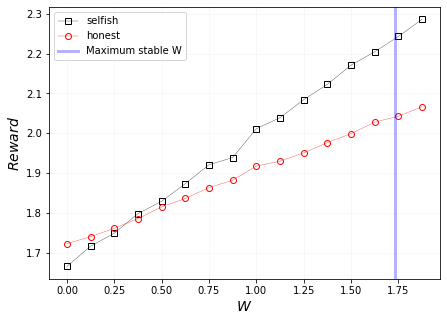

In [320]:
f, ax = plt.subplots(figsize=(7,5))


ax.plot(whales, res_total[::2][:,0], marker='s', color='k', label='selfish', fillstyle='none',
        linewidth=0.3)
ax.plot(whales, res_total[1::2][:,0], marker='o', color='r', label='honest', fillstyle='none',
        linewidth=0.3)
ax.axvline(1.73, linewidth=3, color='b', alpha=0.3, label='Maximum stable W')
ax.grid(alpha=0.1)

ax.set_xlabel(r'$W$', size=14)
ax.set_ylabel(r'$Reward$', size=14)

plt.legend()
plt.show()

In [267]:
policy[2]

0

In [271]:
np.array(policy[:3]) == 0

array([ True,  True,  True])

In [261]:
val_iter.V[0]

1.0090000000000003

In [262]:
WHALE_REWARD * p

1.0

In [231]:
results = []
whales = np.linspace(0,10,20)
total_states = getTotalStates(length=8)
si = Ind(total_states)
for p in [1/9, 2/9, 1/3]:
    temp = []
    for w in whales:
        WHALE_REWARD = w
        t, r = getTR(si, total_states, length=8, p=p)
        val_iter = mdpt.mdp.ValueIteration(t, r, discount=1)
        val_iter.run()
        temp.append(val_iter.V[0])
    results.append(temp)
results = np.asarray(results)

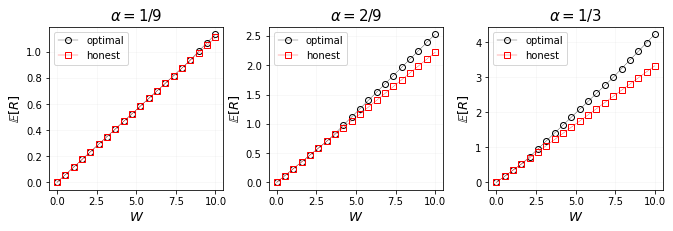

In [232]:
f, axarr = plt.subplots(ncols=3, figsize=(11,3))

axarr[0].plot(whales, results[0], marker='o', fillstyle='none', color='k', linewidth=0.3,
              label='optimal')
axarr[0].plot(whales, whales* 1/9 , marker='s', fillstyle='none', color='r', linewidth=0.3,
              label='honest')

axarr[1].plot(whales, results[1], marker='o', fillstyle='none', color='k', linewidth=0.3,
              label='optimal')
axarr[1].plot(whales, whales* 2/9 , marker='s', fillstyle='none', color='r', linewidth=0.3,
              label='honest')

axarr[2].plot(whales, results[2], marker='o', fillstyle='none', color='k', linewidth=0.3,
              label='optimal')
axarr[2].plot(whales, whales* 3/9 , marker='s', fillstyle='none', color='r', linewidth=0.3,
              label='honest')


for ax in axarr:
    ax.legend()
    ax.set_xlabel(r'$W$', size = 13)
    ax.set_ylabel(r'$\mathbb{E}[R]$', size = 13)
    ax.grid(alpha=0.1)
    
axarr[0].set_title(r'$\alpha=1/9$', size=15)
axarr[1].set_title(r'$\alpha=2/9$', size=15)
axarr[2].set_title(r'$\alpha=1/3$', size=15)

plt.subplots_adjust(wspace=0.26)
plt.show()

In [240]:
si.s(2)

'01,00,1'

In [281]:
results = []
whales = np.linspace(0,10,500)
total_states = getTotalStates(length=8)
si = Ind(total_states)
ps = np.linspace(0.1, 0.49, 20)
old_stdout = sys.stdout # backup current stdout
policies = []
for p in ps:
    min_W = 0
    sys.stdout = open(os.devnull, 'w')
    for w in whales:
        WHALE_REWARD = w
        t, r = getTR(si, total_states, length=8, p=p)
        val_iter = mdpt.mdp.ValueIteration(t, r, discount=1)
        val_iter.run()
        if np.all(np.array(val_iter.policy[:3]) == 0):
            sys.stdout = old_stdout
            print('p={:0.2f}, w={:0.2f}'.format(p, w))
            min_W = w
            policies.append((p, w, val_iter.policy))
            break
    results.append(min_W)
results = np.asarray(results)

p=0.10, w=8.92
p=0.12, w=7.21
p=0.14, w=5.99
p=0.16, w=5.07
p=0.18, w=4.37
p=0.20, w=3.81
p=0.22, w=3.31
p=0.24, w=2.91
p=0.26, w=2.59
p=0.28, w=2.28
p=0.31, w=2.04
p=0.33, w=1.82
p=0.35, w=1.62
p=0.37, w=1.44
p=0.39, w=1.30
p=0.41, w=1.16
p=0.43, w=1.04
p=0.45, w=0.92
p=0.47, w=0.82
p=0.49, w=0.72


In [287]:
p, w

(0.1, 8.917835671342685)

In [350]:
# estimate prob of reorg
iters = int(1e4)
length = 8

probs_of_reorg = []
for p, w, policy in policies:
    reorgs = 0
    t, r = getTR(si, total_states, length=8, p=p)

    for _ in tqdm(range(iters)):
        cur_state = 0
        while True:
            opt_action = policy[cur_state]
            next_states = np.nonzero(t[opt_action, cur_state])[0]
            probs = t[opt_action, cur_state][next_states]
            new_state = np.random.choice(next_states, p=probs)
            if si.s(cur_state)[-1] != si.s(new_state)[-1] and cur_state != 0:
                reorgs += 1
                break
            cur_state = new_state
            if str(length) in si.s(cur_state)[:2]:
                break
    print('p={:0.2f}, prob_reorg={:0.3f}'.format(p, reorgs / iters))
    probs_of_reorg.append(reorgs / iters)

  3%|▎         | 337/10000 [00:00<00:02, 3369.70it/s]

p=0.10, prob_reorg=0.009


  3%|▎         | 336/10000 [00:00<00:02, 3353.93it/s]

p=0.12, prob_reorg=0.016


  3%|▎         | 340/10000 [00:00<00:02, 3396.97it/s]

p=0.14, prob_reorg=0.018


  0%|          | 0/10000 [00:00<?, ?it/s]

p=0.16, prob_reorg=0.025


  3%|▎         | 339/10000 [00:00<00:02, 3382.04it/s]

p=0.18, prob_reorg=0.036


  3%|▎         | 344/10000 [00:00<00:02, 3430.95it/s]

p=0.20, prob_reorg=0.036


  0%|          | 0/10000 [00:00<?, ?it/s]

p=0.22, prob_reorg=0.048


  4%|▎         | 356/10000 [00:00<00:02, 3550.56it/s]

p=0.24, prob_reorg=0.057


  0%|          | 0/10000 [00:00<?, ?it/s]

p=0.26, prob_reorg=0.062


  0%|          | 0/10000 [00:00<?, ?it/s]

p=0.28, prob_reorg=0.075


  3%|▎         | 342/10000 [00:00<00:02, 3413.76it/s]

p=0.31, prob_reorg=0.080


  0%|          | 0/10000 [00:00<?, ?it/s]

p=0.33, prob_reorg=0.093


  7%|▋         | 700/10000 [00:00<00:02, 3501.85it/s]

p=0.35, prob_reorg=0.103


  3%|▎         | 302/10000 [00:00<00:03, 3010.91it/s]

p=0.37, prob_reorg=0.109


  3%|▎         | 332/10000 [00:00<00:02, 3317.35it/s]

p=0.39, prob_reorg=0.121


  7%|▋         | 729/10000 [00:00<00:02, 3643.03it/s]

p=0.41, prob_reorg=0.132


  0%|          | 0/10000 [00:00<?, ?it/s]

p=0.43, prob_reorg=0.139


  4%|▎         | 351/10000 [00:00<00:02, 3504.96it/s]

p=0.45, prob_reorg=0.146


  5%|▌         | 530/10000 [00:00<00:03, 2647.93it/s]

p=0.47, prob_reorg=0.155


100%|██████████| 10000/10000 [00:03<00:00, 2953.99it/s]


p=0.49, prob_reorg=0.167


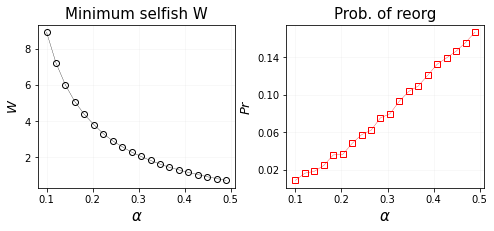

In [351]:
f, axarr = plt.subplots(ncols = 2, figsize=(8,3))

axarr[0].plot(ps, results, marker='o', fillstyle='none', color='k', linewidth=0.3)
axarr[1].plot(ps, probs_of_reorg, marker='s', fillstyle='none', color='r', linewidth=0.3)

axarr[1].set_yticks([0.02, 0.06, 0.10, 0.14])

for ax in axarr:
    ax.set_xlabel(r'$\alpha$', size = 15)
    ax.grid(alpha=0.1)
    
axarr[0].set_title('Minimum selfish W', size=15)
axarr[1].set_title('Prob. of reorg', size=15)

axarr[0].set_ylabel(r'$W$', size=13)
axarr[1].set_ylabel(r'$Pr$', size=13)

plt.subplots_adjust(wspace=0.26)
plt.show()